In [2]:
cd ../

/home/jovyan/work/nyc_data


In [133]:
from src.data import make_dataset
import pyspark
import pandas as pd
import numpy as np
import setting
from src.spark_session import spark
from src.utils import utils
import os
import autoreload
import matplotlib.pyplot as plt
import numpy as np
autoreload.reload(setting)

<module 'setting' from '/home/jovyan/work/nyc_data/setting.py'>

In [57]:
#persist a sampled dataset to work with

nyc_raw = make_dataset.ingest_raw_csv()
nyc_raw_sample = nyc_raw.sample(withReplacement=False, fraction=0.01)
nyc_raw_sample_filepath = os.path.join(setting.data_dir_interim, "nyc_raw_sample.parquet")
nyc_raw_sample.write.parquet(nyc_raw_sample_filepath, mode="overwrite")

2019-03-28 03:46:05,274 - src.data.make_dataset - INFO — ingest_raw_csv:22 - ingesting raw csv file from /home/jovyan/work/nyc_data/data/raw/nyc_raw.csv
2019-03-28 03:46:05,274 - src.data.make_dataset - INFO — ingest_raw_csv:22 - ingesting raw csv file from /home/jovyan/work/nyc_data/data/raw/nyc_raw.csv
2019-03-28 03:46:19,588 - src.data.make_dataset - INFO — ingest_raw_csv:42 - ingested and cleaned raw csv file /home/jovyan/work/nyc_data/data/raw/nyc_raw.csv
2019-03-28 03:46:19,588 - src.data.make_dataset - INFO — ingest_raw_csv:42 - ingested and cleaned raw csv file /home/jovyan/work/nyc_data/data/raw/nyc_raw.csv


In [113]:
nyc_rs_pd = utils.parquet_dir_to_pandas_df(nyc_raw_sample_filepath) 
nyc_rs_pd.reset_index(drop=True, inplace=True)

In [59]:
nyc_rs_pd.dtypes

vendor_id                         int32
pickup_datetime          datetime64[ns]
dropoff_datetime         datetime64[ns]
store_and_fwd_flag               object
ratecode_id                       int32
pu_location_id                    int32
do_location_id                    int32
passenger_count                   int32
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
improvement_surcharge           float64
total_amount                    float64
payment_type                      int32
trip_type                         int32
dtype: object

## Basic visualizations

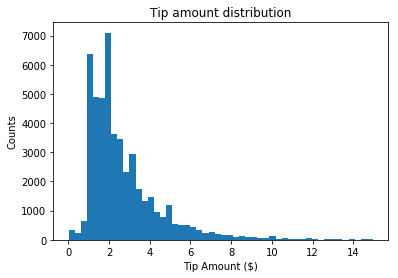

<Figure size 432x432 with 0 Axes>

In [114]:
nyc_rs_pd[(nyc_rs_pd["tip_amount"] <15) & (nyc_rs_pd["tip_amount"] > 0) ]["tip_amount"].plot(kind='hist', bins=50)
plt.title('Tip amount distribution')
plt.xlabel('Tip Amount ($)'); plt.ylabel('Counts');
plt.figure(figsize=(6,6));


<Figure size 504x504 with 0 Axes>

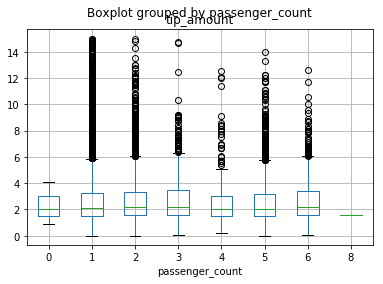

<Figure size 504x504 with 0 Axes>

In [115]:
nyc_rs_pd_f = nyc_rs_pd[ (nyc_rs_pd["tip_amount"] <15) & (nyc_rs_pd["tip_amount"] > 0)]
nyc_rs_pd_f.boxplot(column="tip_amount", by='passenger_count')
# plt.title("tip amount by passenger count")
plt.figure(figsize=(7,7))


In [129]:
trip_duration = nyc_rs_pd["dropoff_datetime"] - nyc_rs_pd["pickup_datetime"] 

In [136]:
nyc_rs_pd["trip_duration_m"] = trip_duration / np.timedelta64(60, 's')

Text(0.5, 0, 'trip duration in minutes')

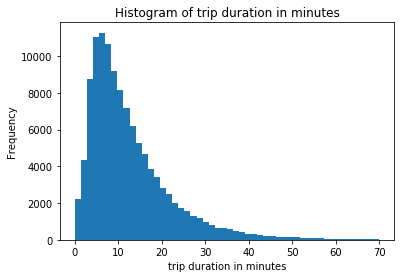

In [144]:
nyc_rs_pd[(nyc_rs_pd["trip_duration_m"] > 0) & (nyc_rs_pd["trip_duration_m"] < 70)]["trip_duration_m"].plot(kind="hist", bins=50)
plt.title("Histogram of trip duration in minutes")
plt.xlabel("trip duration in minutes")

Text(0, 0.5, 'tip amount')

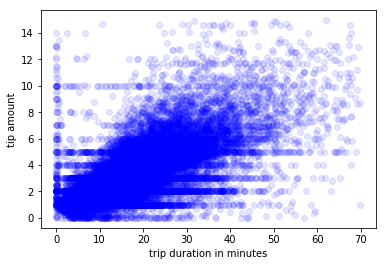

In [148]:
nyc_rs_pd_f = nyc_rs_pd[(nyc_rs_pd["trip_duration_m"] > 0) 
                        & (nyc_rs_pd["trip_duration_m"] < 70)
                       & (nyc_rs_pd["tip_amount"] <15) 
                        & (nyc_rs_pd["tip_amount"] > 0)]
plt.scatter(nyc_rs_pd_f["trip_duration_m"], nyc_rs_pd_f["tip_amount"], c='blue', alpha = 0.10,)
plt.xlabel("trip duration in minutes")
plt.ylabel("tip amount")

Text(0, 0.5, 'tip amount')

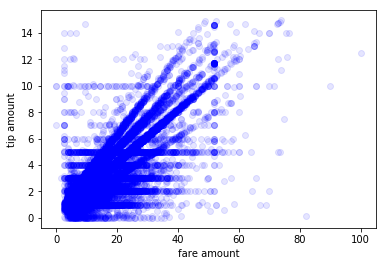

In [149]:
plt.scatter(nyc_rs_pd_f["fare_amount"], nyc_rs_pd_f["tip_amount"], c='blue', alpha = 0.10,)
plt.xlabel("fare amount")
plt.ylabel("tip amount")

### Cardinalities of categorical data

We will treat vendor ID, ratecode ID and payment ID as categorical data

In [153]:

print(nyc_rs_pd["vendor_id"].unique())
print(nyc_batch_pd["ratecode_id"].unique())
print(nyc_batch_pd["payment_type"].unique())
print(nyc_batch_pd["store_and_fwd_flag"].unique())


[2 1]
[1 5 2 3 4]
[1 2 3 4 5]
['N' 'Y']


In [154]:
print(len(nyc_batch_pd["pu_location_id"].unique()))
print(len(nyc_batch_pd["do_location_id"].unique()))

223
253
